**Final- Jason Fan**

api endpoint for places data: https://data.cdc.gov/api/v3/views/swc5-untb/query.geojson

CDC API Key: 5vfz842e0c4t6bl6112x3ijmb
API KEY Secret: 2vu39ajyjwwshgsb49uf5jj91m2ha4qu4qs0mamsvaatx5dzw7

CDC App token: ReEZWmd3hqYSQ879UCZyhtP1T
Secret token: wILhFtlRyqmCR8ttGOXBaUJJ_10gLtUiMQiH

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
import osmnx as ox
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from rasterio.merge import merge
import glob
import os
import platform
import warnings
from sodapy import Socrata
from mapclassify import classify
from shapely.wkt import loads
from shapely.geometry import shape
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import hvplot.pandas

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
np.random.seed(42)

In [3]:
pd.options.display.max_columns = 999

In [4]:
%matplotlib inline

### CDC Health Data 

API Call for CDC Health Data

In [5]:
client = Socrata("data.cdc.gov",
                  'ReEZWmd3hqYSQ879UCZyhtP1T' #my app token here
                  )
dataset_id = "swc5-untb"
results = client.get(dataset_id, limit=250000)
cdc_gdf = gpd.GeoDataFrame.from_records(results)
print(cdc_gdf.head())
print(cdc_gdf.info())

   year stateabbr statedesc locationname datasource         category  \
0  2022        AL   Alabama         Clay      BRFSS  Health Outcomes   
1  2022        AL   Alabama         Dale      BRFSS  Health Outcomes   
2  2022        AL   Alabama      Jackson      BRFSS  Health Outcomes   
3  2022        AL   Alabama   Lauderdale      BRFSS  Health Outcomes   
4  2022        AL   Alabama     Lawrence      BRFSS       Disability   

                       measure data_value_unit          data_value_type  \
0  Current asthma among adults               %         Crude prevalence   
1       Arthritis among adults               %         Crude prevalence   
2          Stroke among adults               %         Crude prevalence   
3         Obesity among adults               %  Age-adjusted prevalence   
4  Any disability among adults               %         Crude prevalence   

  data_value low_confidence_limit high_confidence_limit totalpopulation  \
0       11.0                  9.6        

I created an account on data.cdc.gov to get the API keys and tokens. This way I can call the API to get the cdc data.
Total sataset size is 240,000 rows, I set the limit to 250,000 to get all the data.

In [6]:
#print(cdc_gdf['geolocation'].head())

Code above is to figure out what format the geolocation data is in.

The code following this is to transform the geolocation column into a geometry column that can works well with geopandas. This had to be done since the geolocation column is in a string format that geopandas cannot read directly.

In [7]:
cdc_gdf['geometry'] = cdc_gdf['geolocation'].apply(
    lambda x: shape(x) if not (isinstance(x, float) and np.isnan(x)) else None
)
cdc_gdf = cdc_gdf.set_geometry('geometry', crs="EPSG:4326", drop=True)

C:\Users\Jason Fan\AppData\Local\Temp\ipykernel_24100\622435626.py:1: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  cdc_gdf['geometry'] = cdc_gdf['geolocation'].apply(
C:\Users\Jason Fan\AppData\Local\Temp\ipykernel_24100\622435626.py:4: FutureWarning: The `drop` keyword argument is deprecated and in future the only supported behaviour will match drop=False. To silence this warning and adopt the future behaviour, stop providing `drop` as a keyword to `set_geometry`. To replicate the `drop=True` behaviour you should update your code to
`geo_col_name = gdf.active_geometry_name; gdf.set_geometry(new_geo_col).dro

NA were dropped since they cannot be converted into geometry points.

In [8]:
cdc_gdf = cdc_gdf.dropna(subset=['geometry'])
print(cdc_gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 240806 entries, 0 to 240885
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   year                         240806 non-null  object  
 1   stateabbr                    240806 non-null  object  
 2   statedesc                    240806 non-null  object  
 3   locationname                 240806 non-null  object  
 4   datasource                   240806 non-null  object  
 5   category                     240806 non-null  object  
 6   measure                      240806 non-null  object  
 7   data_value_unit              240806 non-null  object  
 8   data_value_type              240806 non-null  object  
 9   data_value                   240806 non-null  object  
 10  low_confidence_limit         240806 non-null  object  
 11  high_confidence_limit        240806 non-null  object  
 12  totalpopulation              240806 non-n

Currently the data is in points format. I will convert it into a polygon format later on to match the raster data. The polygon format will be at the county level.

### Getting County boundaries

In [9]:
county_url = (
    "https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip"
)

In [10]:
try:
    county_boundaries = gpd.read_file(county_url)
    
    county_crs = county_boundaries.crs
    county_boundaries = county_boundaries.to_crs(county_crs)
    
    county_boundaries['FIPS'] = county_boundaries['STATEFP'] + county_boundaries['COUNTYFP']
    
    county_boundaries_for_merge = county_boundaries.rename(
        columns={'geometry': 'county_polygon'}
    )[['FIPS', 'county_polygon']]
    
except Exception as e:
    county_boundaries_for_merge = gpd.GeoDataFrame()
    county_crs = None

if county_crs:
    print(f"Stored County Boundary CRS: {county_crs}")

Stored County Boundary CRS: EPSG:4269


In [11]:
cdc_gdf['FIPS'] = cdc_gdf['locationid'].astype(str)
cdc_gdf['data_value'] = pd.to_numeric(cdc_gdf['data_value'], errors='coerce')

cdc_data_no_geom = cdc_gdf.drop(columns=['geometry'])

# Merge
merged_gdf_full = cdc_data_no_geom.merge(
    county_boundaries_for_merge, 
    on='FIPS', 
    how='left'
)

merged_gdf_full = gpd.GeoDataFrame(
    merged_gdf_full, 
    geometry='county_polygon', 
    crs=county_crs 
)

In [12]:
merged_gdf_full = merged_gdf_full.rename(columns={'county_polygon': 'geometry'})
merged_gdf_full = merged_gdf_full.set_geometry('geometry')
print(merged_gdf_full.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 240806 entries, 0 to 240805
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   year                         240806 non-null  object  
 1   stateabbr                    240806 non-null  object  
 2   statedesc                    240806 non-null  object  
 3   locationname                 240806 non-null  object  
 4   datasource                   240806 non-null  object  
 5   category                     240806 non-null  object  
 6   measure                      240806 non-null  object  
 7   data_value_unit              240806 non-null  object  
 8   data_value_type              240806 non-null  object  
 9   data_value                   240806 non-null  float64 
 10  low_confidence_limit         240806 non-null  object  
 11  high_confidence_limit        240806 non-null  object  
 12  totalpopulation              240806 

In [13]:
#msa_states = ['PA', 'NJ', 'DE', 'MD']

In [14]:
ne_states = ['PA', 'NJ', 'NY', 'CT', 'RI', 'MA', 'NH', 'VT', 'ME']

In [15]:
#creating filters for the states
states = merged_gdf_full[merged_gdf_full['stateabbr'].str.contains(
    '|'.join(ne_states), case=False, na=False)].copy()

In [16]:
print(states.head())
#double checking that if it actually works

     year stateabbr      statedesc locationname datasource         category  \
231  2022        ME          Maine   Cumberland      BRFSS  Health Outcomes   
232  2022        ME          Maine        Waldo      BRFSS       Disability   
236  2022        MA  Massachusetts      Bristol      BRFSS  Health Outcomes   
237  2022        MA  Massachusetts     Franklin      BRFSS  Health Outcomes   
238  2022        MA  Massachusetts      Norfolk      BRFSS  Health Outcomes   

                             measure data_value_unit   data_value_type  \
231              Stroke among adults               %  Crude prevalence   
232  Hearing disability among adults               %  Crude prevalence   
236             Obesity among adults               %  Crude prevalence   
237             Obesity among adults               %  Crude prevalence   
238             Obesity among adults               %  Crude prevalence   

     data_value low_confidence_limit high_confidence_limit totalpopulation  \
23

Cropping the county boundaries to a slightly more accurate (albeit still largely inaccurate) shape to represent the coastline. This is done since the county boundaries includes a lot of water area that skews the analysis later on. As we are trying to use zonal statistics to get the average values of raster data within each county, having a lot of water area will skew the results.

In [17]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

usa_land = world[world['ADMIN'] == "United States of America"]

usa_land = usa_land.to_crs(states.crs)

# Clip to land area only
states_gdf = gpd.clip(states, usa_land)

### (old) Getting census tract polygons for MSA instead due to county level being too large of an area to get accurate zonal stats.

In [18]:
#from tqdm import tqdm
#state_fips_codes = ['42', '34', '10', '24'] 
#base_url = "https://www2.census.gov/geo/tiger/TIGER2020/TRACT/"

#for fips in tqdm(state_fips_codes, desc="Downloading Tracts"):
#    url = f"{base_url}tl_2020_{fips}_tract.zip"
#    try:
#        gdf_tracts = gpd.read_file(url)
#        tract_boundaries.append(gdf_tracts)
#    except Exception as e:
#        print(f"Error downloading tracts for FIPS {fips}: {e}")

#tracts_gdf = pd.concat(tract_boundaries, ignore_index=True)
#tracts_gdf = tracts_gdf.set_crs("EPSG:4326", allow_override=True)
#tracts_gdf['TRACT_FIPS'] = tracts_gdf['STATEFP'] + tracts_gdf['COUNTYFP'] + tracts_gdf['TRACTCE']
#tracts_gdf = tracts_gdf[['TRACT_FIPS', 'geometry']]
#print(tracts_gdf.info())

#philly_msa_county_fips = [
#    '42017', '42029', '42045', '42091', '42101',
#    '34005', '34007', '34015', '34033',
#    '10003',
#    '24015'
#]

#tracts_gdf['COUNTY_FIPS'] = tracts_gdf['TRACT_FIPS'].str[:5]

#philly_tracts_gdf = tracts_gdf[
#    tracts_gdf['COUNTY_FIPS'].isin(philly_msa_county_fips)
#].copy()

#philly_tracts_gdf = philly_tracts_gdf.drop(columns=['COUNTY_FIPS'])
#print(philly_tracts_gdf.head())

#cdc_points_philly = cdc_gdf[cdc_gdf['locationid'].isin(philly_msa_county_fips)].copy()
#philly_tracts_gdf = philly_tracts_gdf.to_crs(cdc_points_philly.crs)
#print(len(cdc_points_philly))
#print(len(philly_tracts_gdf))

#spatial_join_result = gpd.sjoin(
#    cdc_points_philly,
#    philly_tracts_gdf[['TRACT_FIPS', 'geometry']],
#    how='left'
#)
#print(spatial_join_result[['locationname', 'measure', 'data_value', 'TRACT_FIPS', 'geometry']].head())

#plot spatial_join_result
#spatial_join_result = spatial_join_result.#set_geometry('geometry')
#spatial_join_result.plot(column='measure', #figsize=(10, 6))
#cdc_points_philly.plot(ax=plt.gca(), #color='red', markersize=5)
#philly_tracts_gdf.boundary.plot(ax=plt.gca(), #color='gray', linewidth=0.5)

get state census tracts in the four states that make up the Philadelphia MSA: Pennsylvania, New Jersey, Delaware, and Maryland. Then filter to only include tracts in the counties that are part of the MSA.

(edit: it turns out the point data represents county centroids rather than individual data points. Therefore, I will revert back to using county polygons for the zonal stats. To make sure the data is useful, I will go beyond the MSA and get all counties in the four states.)

There's less points then census tracts, which means that some census tracts do not have any CDC data points in them.

Only after plotting it out did i realise that the points are just county centroids rather than individual data points within the county. 

### Code for noise pollution data

In [19]:
import subprocess

Used AI to aid in writing the following code for merging rasters

Created a virtual raster (.vrt) file since not doing this meant creating a 55+gb file

Also I just have zero idea how to create or use a virtual raster file

In [20]:
data_dir = "data/CONUS_rail_road_and_aviation_noise_2020/State_rasters/"
search_pattern = os.path.join(data_dir, "*_rail_road_and_aviation_noise_2020.tif")
output_vrt = os.path.join(data_dir, "CONUS_merged_noise_map_2020.vrt")

tif_files = glob.glob(search_pattern)

if not tif_files:
    print(f"--- ERROR ---")
    print(f"No .tif files were found at: {search_pattern}")
else:
    print(f"Found {len(tif_files)} state raster files to link.")
    
    command_list = ["gdalbuildvrt", output_vrt] + tif_files
    
    print("Building VRT file...")
    
    try:
        subprocess.run(command_list, check=True, shell=True)
        
        print(f"\n--- Success! ---")
        print(f"Virtual Raster .vrt file created at:")
        print(output_vrt)
        
    except subprocess.CalledProcessError as e:
        print(f"\n--- GDAL ERROR ---")
        print(f"The command failed: {e}")
        print("Please ensure GDAL is installed in your active Conda environment.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Found 49 state raster files to link.
Building VRT file...

--- Success! ---
Virtual Raster .vrt file created at:
data/CONUS_rail_road_and_aviation_noise_2020/State_rasters/CONUS_merged_noise_map_2020.vrt


Calling from the virtual raster file to read the merged raster data

In [21]:
data_dir = "data/CONUS_rail_road_and_aviation_noise_2020/State_rasters/"
noise_map_file = os.path.join(data_dir, "CONUS_merged_noise_map_2020.vrt")

Making sure the file exists

In [22]:
if not os.path.exists(noise_map_file):
    print(f"--- ERROR ---")
    print(f"Could not find the VRT file at: {noise_map_file}")
    print("Please make sure you've created this file and the path is correct.")
else:
    print(f"Using Virtual Raster: {noise_map_file}")

Using Virtual Raster: data/CONUS_rail_road_and_aviation_noise_2020/State_rasters/CONUS_merged_noise_map_2020.vrt


In [23]:
#just looking at the metadata to figure out what to do with this
#noise_map = rasterio.open(noise_map_file)
#noise_map.meta

### Zonal Statistics

Running this with the national dataset is taking far too long (currently at 134 mins and still going). I will try to run this on a smaller subset of the data first to make sure the code works. While I don't want to run it at too small a subset.

In [24]:
from rasterstats import zonal_stats
import multiprocessing
from shapely.geometry import Point

In [25]:
unique_counties_gdf = states_gdf[['locationid', 'geometry']].drop_duplicates(subset='locationid').copy()

In [26]:
from tqdm import tqdm

In [27]:
#this opens the raster and reads in the data
with rasterio.open(noise_map_file) as src:
    target_crs = src.crs
    nodata_val = src.nodata

In [28]:
#unique_counties_gdf['geometry'] = unique_counties_gdf['geometry'].simplify(0.005, preserve_topology=True)
unique_counties_gdf = unique_counties_gdf.to_crs(target_crs)

In [29]:
num_cpus = os.cpu_count() or 1
cpus_to_use = max(1, num_cpus - 1)

For the standard deviation calculation, I looked at mean, max, count, and standard deviation. I looked into mean to find the average noise pollution level in each county. Max was looked into to find the highest noise pollution level in each county. Count was looked into to find how many raster cells were within each county. Standard deviation looked into to find how varied the noise pollution levels were within each county.

Looking at mean alone was not sufficient since I was unable to make the areas with no data 0. This meant that areas with no data were excluded from the mean calculation, which skewed the results. For example, a county with only one raster cell with a value of 70 would have a mean of 70, even if the rest of the county had no data. By looking at count, I was able to identify counties with very few raster cells and treat them differently in the analysis.

In [30]:
warnings.filterwarnings("ignore", category=UserWarning)
stats = zonal_stats(
    unique_counties_gdf,   
    noise_map_file,
    stats=['mean', 'max','count','std'],         
    all_touched=True,      
    band=1,
    nodata=nodata_val,       
    cpus=cpus_to_use 
)

In [31]:
results_df = pd.DataFrame(stats)
results_df['locationid'] = unique_counties_gdf['locationid'].values
results_df = results_df.rename(columns={'mean': 'avg_noise_db_county',
                                          'max': 'max_noise_db',
                                          'std': 'std_noise_db',
                                          'count': 'count_noise'
                                         })

In [32]:
columns_to_keep = [
    'locationid', 
    'avg_noise_db_county', 
    'max_noise_db', 
    'std_noise_db', 
    'count_noise'
]

In [33]:
states_gdf = states_gdf.merge(
    results_df[columns_to_keep], 
    on='locationid', 
    how='left'
)

### results of analysis

In [34]:
print(f"Total rows in states_gdf: {len(states_gdf)}")
print(f"Non-null noise values: {states_gdf['avg_noise_db_county'].count()}")
print(states_gdf[['locationname', 'stateabbr', 'avg_noise_db_county','max_noise_db', 'std_noise_db', 'count_noise']].head())

Total rows in states_gdf: 15554
Non-null noise values: 15474
  locationname stateabbr  avg_noise_db_county  max_noise_db  std_noise_db  \
0     Cape May        NJ            52.449437    105.100006       6.63727   
1     Cape May        NJ            52.449437    105.100006       6.63727   
2     Cape May        NJ            52.449437    105.100006       6.63727   
3     Cape May        NJ            52.449437    105.100006       6.63727   
4     Cape May        NJ            52.449437    105.100006       6.63727   

   count_noise  
0        64474  
1        64474  
2        64474  
3        64474  
4        64474  


### Test for getting coverage percentage

In [35]:
import rasterio
import pandas as pd

# 1. Robust Column Check (Find the count column)
if 'count_noise' in results_df.columns:
    count_col = 'count_noise'
elif 'count' in results_df.columns:
    count_col = 'count'
else:
    # If missing, try to get it from states_gdf
    temp_df = states_gdf[['locationid', 'count_noise']].drop_duplicates()
    results_df = results_df.merge(temp_df, on='locationid', how='left')
    count_col = 'count_noise'

# 2. Get Pixel Size (Resolution)
with rasterio.open(noise_map_file) as src:
    res_x, res_y = src.res
    pixel_area = abs(res_x * res_y)

# 3. Merge pixel counts into the unique counties
# We use unique_counties_gdf to avoid duplicate rows
county_coverage = unique_counties_gdf.merge(
    results_df[['locationid', count_col]], 
    on='locationid', 
    how='left'
)

# 4. Perform the Math
# Covered Area = Pixels * Pixel Size
county_coverage['covered_area'] = county_coverage[count_col] * pixel_area
# Total Area = Polygon Size
county_coverage['total_area'] = county_coverage.geometry.area
# Percentage
county_coverage['percent_covered'] = (county_coverage['covered_area'] / county_coverage['total_area']) * 100

# 5. Add Readable Names (State and County Name)
# We map these from states_gdf so you can read the output
name_map = states_gdf[['locationid', 'locationname', 'stateabbr']].drop_duplicates()
county_coverage = county_coverage.merge(name_map, on='locationid', how='left')

# 6. Display Results
# Show counties with the LOWEST coverage (Partial data or Coastal mismatch)
print("--- COUNTIES WITH LOWEST COVERAGE ---")
cols_to_show = ['locationname', 'stateabbr', 'percent_covered', 'covered_area']
print(county_coverage[cols_to_show].sort_values(by='percent_covered').head(10))

# Show counties with HIGHEST coverage (Should be near 100%)
print("\n--- COUNTIES WITH HIGHEST COVERAGE ---")
print(county_coverage[cols_to_show].sort_values(by='percent_covered', ascending=False).head(5))

--- COUNTIES WITH LOWEST COVERAGE ---
    locationname stateabbr  percent_covered  covered_area
156        Dukes        MA         0.000000  0.000000e+00
215  Piscataquis        ME         0.298564  3.385440e+07
123     Hamilton        NY         0.327404  1.532970e+07
128        Lewis        NY         0.547181  1.830690e+07
211   Washington        ME         0.666833  4.848840e+07
213     Somerset        ME         0.686499  7.137900e+07
216    Aroostook        ME         0.692764  1.207395e+08
71        Potter        PA         0.723443  2.026350e+07
201        Essex        VT         0.787524  1.365120e+07
126      Orleans        NY         0.809200  1.697040e+07

--- COUNTIES WITH HIGHEST COVERAGE ---
     locationname stateabbr  percent_covered  covered_area
131        Queens        NY        78.303847  2.186370e+08
6    Philadelphia        PA        70.428525  2.602953e+08
135         Bronx        NY        64.571627  9.594630e+07
137         Union        NJ        61.567804  1.

In [36]:
states_gdf = states_gdf.merge(
    county_coverage[['locationid', 'percent_covered']], 
    on='locationid', 
    how='left'
)
print(states_gdf[['locationname', 'stateabbr', 'avg_noise_db_county', 'percent_covered']].head())

  locationname stateabbr  avg_noise_db_county  percent_covered
0     Cape May        NJ            52.449437         8.778856
1     Cape May        NJ            52.449437         8.778856
2     Cape May        NJ            52.449437         8.778856
3     Cape May        NJ            52.449437         8.778856
4     Cape May        NJ            52.449437         8.778856


### transforming states_gdf to long orientation to make the measures columns

In [37]:
pivoted_df = states_gdf.pivot_table(
    index=['FIPS', 'geometry','stateabbr', 'locationname','percent_covered', 'avg_noise_db_county', 'max_noise_db', 'std_noise_db', 'count_noise'], 
    columns='measure', 
    values='data_value',
    aggfunc='mean'
).reset_index()
pivoted_df.columns.name = None
final_gdf = gpd.GeoDataFrame(pivoted_df, geometry='geometry')
print(final_gdf.head())

    FIPS                                           geometry stateabbr  \
0  09110  POLYGON ((-72.33393 41.64277, -72.33392 41.642...        CT   
1  09120  POLYGON ((-73.14601 41.25581, -73.1439 41.2571...        CT   
2  09130  POLYGON ((-72.24852 41.27534, -72.295 41.27, -...        CT   
3  09140  POLYGON ((-73.0671 41.30033, -73.06665 41.2999...        CT   
4  09150  POLYGON ((-72.23445 41.95846, -72.23434 41.958...        CT   

                     locationname  percent_covered  avg_noise_db_county  \
0                         Capitol        11.079371            52.922630   
1              Greater Bridgeport        13.727702            53.615358   
2  Lower Connecticut River Valley         5.831715            53.532019   
3                Naugatuck Valley         8.790596            53.113892   
4        Northeastern Connecticut         3.254717            53.978833   

   max_noise_db  std_noise_db  count_noise  \
0    114.820938      7.343834       333564   
1    107.210541   

### Regression Analysis

In [38]:
non_feature = [
    'FIPS', 'geometry','stateabbr', 'locationname','percent_covered', 
    'avg_noise_db_county', 'max_noise_db', 'std_noise_db', 'count_noise']

In [39]:
clean_data = final_gdf.dropna(subset=['avg_noise_db_county', 'percent_covered'])

X = clean_data.drop(columns=non_feature)
X = X.dropna()
y = clean_data.loc[X.index, 'avg_noise_db_county']

weights = clean_data.loc[X.index, 'percent_covered']

In [40]:
#70-30 train-test split including weights
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.3, random_state=42
)

### Linear Regression Model

In [41]:
lr_model = LinearRegression()

In [42]:
lr_model.fit(X_train, y_train, sample_weight=w_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [43]:
train_score = lr_model.score(X_train, y_train)
test_score = lr_model.score(X_test, y_test)
print(f"Train R²: {train_score:.4f}")
print(f"Test R²: {test_score:.4f}")

Train R²: 0.5046
Test R²: -11.0818


Train R²: 0.5046
Test R²: -11.0818

High negative test R² indicates severe overfitting. The model performs well on the training data but poorly on unseen test data. This is horrible multi-collinearity. I will try random forest next to see if it can help with the overfitting issue.

### Ridge Regression Model

In [44]:
linear_pipe = make_pipeline(StandardScaler(), Ridge(alpha=10.0))

In [45]:
linear_pipe.fit(X_train, y_train, ridge__sample_weight=w_train)

,steps,"[('standardscaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,10.0
,fit_intercept,True
,copy_X,True
,max_iter,None


In [46]:
training_score = linear_pipe.score(X_train, y_train)
test_score = linear_pipe.score(X_test, y_test)
print(f"Ridge Train R²: {training_score:.4f}")
print(f"Ridge Test R²: {test_score:.4f}")

Ridge Train R²: 0.2866
Ridge Test R²: -2.8914


### Random Forest Regression Model

In [47]:
forest_pipe = make_pipeline(
    StandardScaler(), 
    RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
)

In [48]:
forest_pipe.fit(X_train, y_train, randomforestregressor__sample_weight=w_train)

,steps,"[('standardscaler', ...), ('randomforestregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,criterion,'squared_error'
,max_depth,5
,min_samples_split,2


In [49]:
training_score = forest_pipe.score(X_train, y_train)
test_score = forest_pipe.score(X_test, y_test)
print(f"Random Forest Train R²: {training_score:.4f}")
print(f"Random Forest Test R²: {test_score:.4f}")

Random Forest Train R²: 0.7830
Random Forest Test R²: -0.4820


### Identifying Multicollinearity Issues

Checking Correlation Matrix

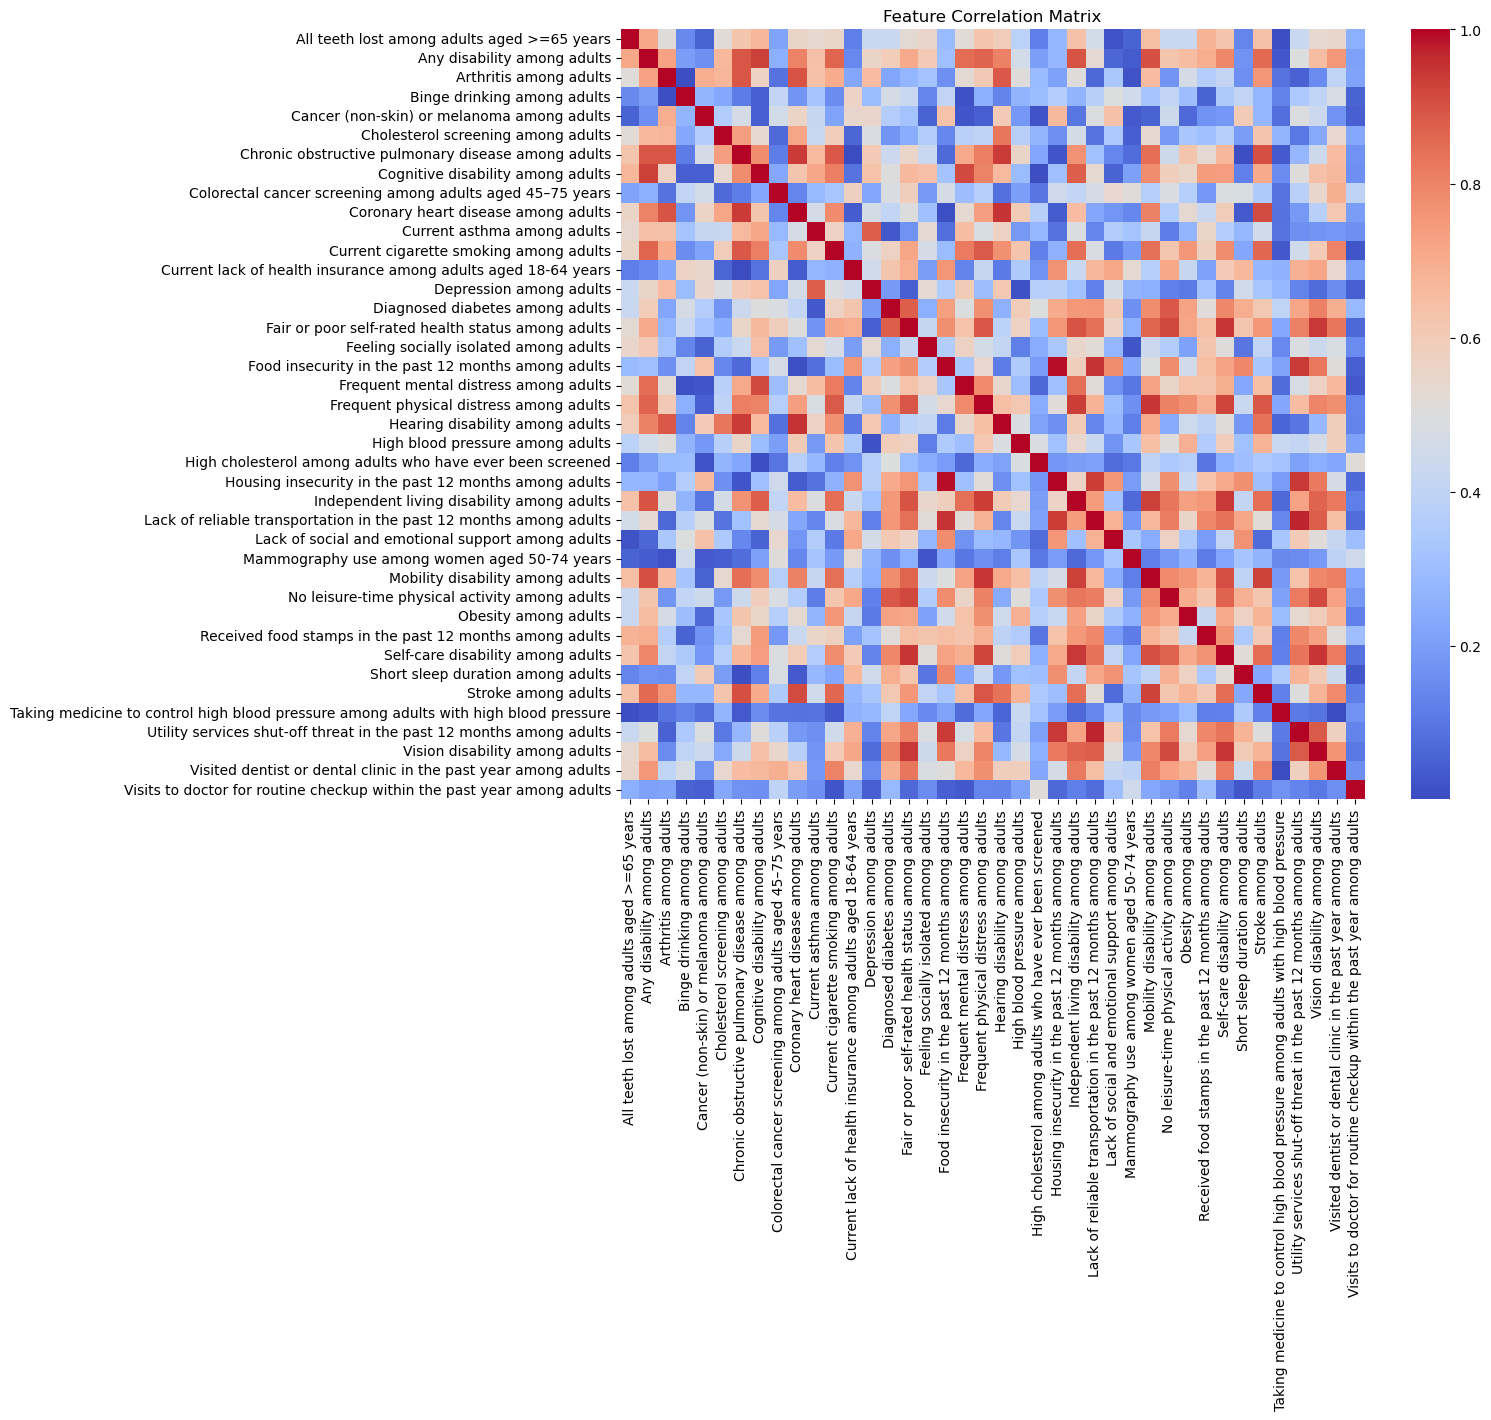

Features to consider dropping due to high correlation:
['Chronic obstructive pulmonary disease among adults', 'Cognitive disability among adults', 'Coronary heart disease among adults', 'Current cigarette smoking among adults', 'Depression among adults', 'Fair or poor self-rated health status among adults', 'Frequent mental distress among adults', 'Frequent physical distress among adults', 'Hearing disability among adults', 'Housing insecurity in the past 12 months among adults', 'Independent living disability among adults', 'Lack of reliable transportation in the past 12 months among adults', 'Mobility disability among adults', 'No leisure-time physical activity among adults', 'Self-care disability among adults', 'Stroke among adults', 'Utility services shut-off threat in the past 12 months among adults', 'Vision disability among adults']


In [50]:
corr_matrix = X_train.corr().abs()

# Plot it
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Automated check: Find pairs with correlation > 0.85
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

print("Features to consider dropping due to high correlation:")
print(to_drop)

consider controlling for: 

'Current cigarette smoking among adults', 'Housing insecurity in the past 12 months among adults', 'Lack of reliable transportation in the past 12 months among adults', 'No leisure-time physical activity among adults', 'Utility services shut-off threat in the past 12 months among adults', 'Feeling socially isolated among adults', 'Binge drinking among adults',  'Short sleep duration among adults', 'Lack of social and emotional support among adults', 'Food insecurity in the past 12 months among adults', 'Received food stamps in the past 12 months among adults','Current lack of health insurance among adults aged 18-64 years', 'Cholesterol screening among adults', 'Colorectal cancer screening among adults aged 45–75 years', 'Mammography use among women aged 50-74 years', 'Visited dentist or dental clinic in the past year among adults', 'Visits to doctor for routine checkup within the past year among adults'



Features to keep: 'Depression among adults', 'Arthritis among adults', 'Cancer (non-skin) or melanoma among adults', 'Chronic obstructive pulmonary disease among adults', 'Cognitive disability among adults', 'Coronary heart disease among adults', 'Current asthma among adults', 'Diagnosed diabetes among adults', 'Fair or poor self-rated health status among adults', 'Frequent mental distress among adults', 'Hearing disability among adults', 'High blood pressure among adults', 'High cholesterol among adults who have ever been screened', 'Mobility disability among adults', 'Obesity among adults', 'Stroke among adults', 'Vision disability among adults', 




In [51]:
features_to_use = ['Current cigarette smoking among adults', 'Housing insecurity in the past 12 months among adults', 'Lack of reliable transportation in the past 12 months among adults', 'No leisure-time physical activity among adults', 'Utility services shut-off threat in the past 12 months among adults', 'Feeling socially isolated among adults', 'Binge drinking among adults',  'Short sleep duration among adults', 'Lack of social and emotional support among adults', 'Food insecurity in the past 12 months among adults', 'Received food stamps in the past 12 months among adults','Current lack of health insurance among adults aged 18-64 years', 'Cholesterol screening among adults', 'Colorectal cancer screening among adults aged 45–75 years', 'Mammography use among women aged 50-74 years', 'Visited dentist or dental clinic in the past year among adults', 'Visits to doctor for routine checkup within the past year among adults', 'Depression among adults', 'Arthritis among adults', 'Cancer (non-skin) or melanoma among adults', 'Chronic obstructive pulmonary disease among adults', 'Cognitive disability among adults', 'Coronary heart disease among adults', 'Current asthma among adults', 'Diagnosed diabetes among adults', 'Fair or poor self-rated health status among adults', 'Frequent mental distress among adults', 'Hearing disability among adults', 'High blood pressure among adults', 'High cholesterol among adults who have ever been screened', 'Mobility disability among adults', 'Obesity among adults', 'Stroke among adults', 'Vision disability among adults']

In [52]:
X = clean_data[features_to_use].dropna()
y = clean_data.loc[X.index, 'avg_noise_db_county']
weights = clean_data.loc[X.index, 'percent_covered']

### Checking Variance Inflation Factor (VIF) for multicollinearity

Ran into issues with calculating VIF due to presence of NaN values. Need to handle NaN values before calculating VIF. Just ended up remaking the data and splitting the data again. 

In [53]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.3, random_state=42
)

In [54]:
X_train_clean = X_train.replace([np.inf, -np.inf], np.nan).dropna()

In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(df):
    # Filter to numeric columns only just in case
    df = df.select_dtypes(include=[np.number])
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    
    # Calculate VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) 
                       for i in range(len(df.columns))]
    return vif_data

In [56]:
vif_df = calculate_vif(X_train_clean)
print(vif_df.sort_values('VIF', ascending=False).head(15))

                                              feature           VIF
32                                Stroke among adults  12564.039821
15  Visited dentist or dental clinic in the past y...  12271.083313
16  Visits to doctor for routine checkup within th...  12173.295604
22                Coronary heart disease among adults  11558.514900
33                     Vision disability among adults   7268.971562
21                  Cognitive disability among adults   6619.330047
1   Housing insecurity in the past 12 months among...   6589.404821
25  Fair or poor self-rated health status among ad...   6388.100349
9   Food insecurity in the past 12 months among ad...   5104.550631
2   Lack of reliable transportation in the past 12...   5085.999147
27                    Hearing disability among adults   5076.542030
26              Frequent mental distress among adults   4618.203168
23                        Current asthma among adults   4346.083840
20  Chronic obstructive pulmonary disease among 

getting new features to use based on correlation matrix and domain knowledge

In [57]:
thresh = 10
X_train_reduced = X_train_clean.copy()
while True:
    # 1. Calculate VIF
    vif_df = calculate_vif(X_train_reduced)
    
    # 2. Find the feature with the max VIF
    max_vif = vif_df['VIF'].max()
    max_feature = vif_df.sort_values('VIF', ascending=False).iloc[0]['feature']
    
    # 3. Check against threshold
    if max_vif > thresh:
        print(f"Dropping '{max_feature}' with VIF: {max_vif:.2f}")
        X_train_reduced = X_train_reduced.drop(columns=[max_feature])
    else:
        print(f"\nSuccess! All remaining features have VIF < {thresh}")
        print("Remaining features:", X_train_reduced.columns.tolist())
        break

# 4. Show final VIF scores
print("\n--- Final VIF Scores ---")
print(calculate_vif(X_train_reduced).sort_values('VIF', ascending=False))

Dropping 'Stroke among adults' with VIF: 12564.04
Dropping 'Visits to doctor for routine checkup within the past year among adults' with VIF: 11200.46
Dropping 'Coronary heart disease among adults' with VIF: 8104.33
Dropping 'Fair or poor self-rated health status among adults' with VIF: 5188.29
Dropping 'Visited dentist or dental clinic in the past year among adults' with VIF: 4146.22
Dropping 'Housing insecurity in the past 12 months among adults' with VIF: 3827.68
Dropping 'Lack of reliable transportation in the past 12 months among adults' with VIF: 3081.55
Dropping 'Current asthma among adults' with VIF: 2984.73
Dropping 'Frequent mental distress among adults' with VIF: 2838.59
Dropping 'Mammography use among women aged 50-74 years' with VIF: 2081.06
Dropping 'Arthritis among adults' with VIF: 1912.13
Dropping 'Hearing disability among adults' with VIF: 1706.45
Dropping 'Cognitive disability among adults' with VIF: 1586.80
Dropping 'Feeling socially isolated among adults' with VIF:

In [58]:
cols_to_keep = X_train_reduced.columns
X_test_reduced = X_test[cols_to_keep]

# Now run your Random Forest on the reduced data
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# 2. Fit the model on your reduced training data
rf_model.fit(X_train_reduced, y_train)

# 3. Score it on the reduced test data
print(f"New Test Score: {rf_model.score(X_test_reduced, y_test):.4f}")

New Test Score: -0.3286


The VIF is still negative which is a major issue. I will try to split the data differently to see if that helps.

### Trying out spatial split by state rather than random split by counties to see if this makes a difference. Also K-fold cross validation with spatial split.

In [59]:
#making sure that all X,y, and groups are all the same df
X = clean_data[features_to_use]
y = clean_data['avg_noise_db_county']
groups = clean_data['stateabbr']

In [60]:
rf_tuned = RandomForestRegressor(
    n_estimators=100, 
    max_depth=5,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42
)

rf_tuned.fit(X_train, y_train)
print(f"Tuned Model Test R2: {rf_tuned.score(X_test, y_test):.4f}")

Tuned Model Test R2: -0.1235


In [61]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=3)

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
    # Split data based on STATE groups
    X_train_g, X_test_g = X.iloc[train_idx], X.iloc[test_idx]
    y_train_g, y_test_g = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train
    rf_tuned.fit(X_train_g, y_train_g)
    score = rf_tuned.score(X_test_g, y_test_g)
    
    # See which states were in the test set
    test_states = groups.iloc[test_idx].unique()
    print(f"Fold {i+1} (Testing on {test_states}): R2 = {score:.4f}")

Fold 1 (Testing on ['PA' 'RI']): R2 = 0.0260
Fold 2 (Testing on ['NH' 'NY']): R2 = 0.0393
Fold 3 (Testing on ['CT' 'ME' 'MA' 'NJ' 'VT']): R2 = 0.0444


### seems like socio econonmic factors are much more strongly correlated with noise pollution than health factors

In [62]:
import cenpy
available = cenpy.explorer.available()
acs = available.filter(regex="^ACS", axis=0)
available.filter(regex="^ACSDT5Y", axis=0)

f:\Anaconda\envs\geo\Lib\site-packages\cenpy\explorer.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  listcols = raw_table.applymap(lambda x: isinstance(x, list)).any()


,c_isTimeseries,temporal,spatial,c_isAggregate,publisher,references,programCode,modified,license,keyword,identifier_url,contactPoint,distribution,description,bureauCode,accessLevel,title,c_isAvailable,c_isCube,c_isMicrodata,c_documentationLink,c_dataset,vintage
ACSDT5Y2009,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2019-08-27 13:11:18.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",https://api.census.gov/data/id/ACSDT5Y2009,"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",The American Community Survey (ACS) is an ongo...,006:07,public,American Community Survey: 5-Year Estimates: D...,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2009.0
ACSDT5Y2010,NaN,NaN,United States,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-04 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",https://api.census.gov/data/id/ACSDT5Y2010,"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2010.0
ACSDT5Y2011,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-04 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",https://api.census.gov/data/id/ACSDT5Y2011,"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2011.0
ACSDT5Y2012,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-04 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",https://api.census.gov/data/id/ACSDT5Y2012,"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2012.0
ACSDT5Y2013,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-04 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",https://api.census.gov/data/id/ACSDT5Y2013,"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2013.0
ACSDT5Y2014,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-04 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",https://api.census.gov/data/id/ACSDT5Y2014,"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2014.0
ACSDT5Y2015,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-05 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",https://api.census.gov/data/id/ACSDT5Y2015,"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2015.0
ACSDT5Y2016,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-05 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",https://api.census.gov/data/id/ACSDT5Y2016,"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",The Ameri

In [63]:
acs = cenpy.remote.APIConnection("ACSDT5Y2023")
acs.variables.head(n=5)

,label,concept,predicateType,group,limit,predicateOnly,hasGeoCollectionSupport,attributes,required
for,Census API FIPS 'for' clause,Census API Geography Specification,fips-for,N/A,0,True,NaN,NaN,NaN
in,Census API FIPS 'in' clause,Census API Geography Specification,fips-in,N/A,0,True,NaN,NaN,NaN
ucgid,Uniform Census Geography Identifier clause,Census API Geography Specification,ucgid,N/A,0,True,True,NaN,NaN
B24022_060E,Estimate!!Total:!!Female:!!Service occupations...,Sex by Occupation and Median Earnings in the P...,int,B24022,0,NaN,NaN,"B24022_060EA,B24022_060M,B24022_060MA",NaN
B19001B_014E,"Estimate!!Total:!!$100,000 to $124,999",Household Income in the Past 12 Months (in 202...,int,B19001B,0,NaN,NaN,"B19001B_014EA,B19001B_014M,B19001B_014MA",NaN


In [64]:
acs_vars = [
    "NAME",
    "B01003_001E", #Total Population
    "B19013_001E", #Median Income 
    "B17001_001E", #Poverty Denom    
    "B17001_002E", #Poverty Count   
    "B02001_001E", #Race Total
    "B02001_002E", #White Count
    "B02001_003E", #Black Count
    "B03003_003E", #Hispanic Count
    "B02001_005E", #Asian Count
    "B23025_003E", #Labor Force
    "B23025_005E", #Unemployed
    "B15003_001E", #Pop 25+
    "B15003_022E", #Bachelors
    "B15003_023E", #Masters
    "B15003_024E", #Professional
    "B15003_025E" #Doctorate 
]

fips_codes = ["42", "34", "36", "09", "44", "25", "23", "50", "33"]

In [65]:
dfs = []
for fips in fips_codes:
    try:
        data = acs.query(
            cols=acs_vars,
            geo_unit="county:*",
            geo_filter={"state": fips}
        )
        dfs.append(data)
    except Exception as e:
        print(f"Error fetching state {fips}: {e}")

In [66]:
if dfs:
    census_df = pd.concat(dfs)
    
    # Create a 'locationid' to match your existing states_gdf
    census_df['locationid'] = census_df['state'] + census_df['county']
    
    # Rename columns for clarity
    census_df = census_df.rename(columns={
         "B01003_001E": "Total Population",
         "B19013_001E": "Median Income",
         "B17001_001E": "Poverty Denom",
         "B17001_002E": "Poverty Count",
         "B02001_001E": "Race Total",
         "B02001_002E": "White Count",
         "B02001_003E": "Black Count",
         "B03003_003E": "Hispanic Count",
         "B02001_005E": "Asian Count",
         "B23025_003E": "Labor Force",
         "B23025_005E": "Unemployed",
         "B15003_001E": "Pop 25+",
         "B15003_022E": "Bachelors",
         "B15003_023E": "Masters",
         "B15003_024E": "Professional",
         "B15003_025E": "Doctorate"
    })

    numeric_cols = ["Total Population", "Median Income", "Poverty Denom", "Poverty Count",
                    "Race Total", "White Count", "Black Count", "Hispanic Count", "Asian Count",
                    "Labor Force", "Unemployed", "Pop 25+", "Bachelors", "Masters", "Professional", "Doctorate"]
    
    for col in numeric_cols:
        census_df[col] = pd.to_numeric(census_df[col], errors='coerce')

    #Poverty Rate calculation
    census_df['Poverty Rate'] = census_df['Poverty Count'] / census_df['Poverty Denom'] * 100

    #unemployment rate calculation
    census_df['Unemployment Rate'] = census_df['Unemployed'] / census_df['Labor Force'] * 100

    #race percentage
    census_df['White Percentage'] = census_df['White Count'] / census_df["Race Total"] * 100
    census_df['Black Percentage'] = census_df['Black Count'] / census_df["Race Total"] * 100
    census_df['Hispanic Percentage'] = census_df['Hispanic Count'] / census_df["Race Total"] * 100
    census_df['Asian Percentage'] = census_df['Asian Count'] / census_df["Race Total"] * 100

    #education
    census_df['Higher Education Rate'] = (census_df['Bachelors'] + census_df['Masters'] + census_df['Professional'] + census_df['Doctorate']) / census_df['Pop 25+'] * 100

    #doing this to match the column name in clean_data
    census_df = census_df.rename(columns={'locationid': 'FIPS'})

    output_cols = [
        'FIPS', 'Total Population', 'Median Income', 'Poverty Rate',
        'Unemployment Rate', 'White Percentage', 'Black Percentage',
        'Hispanic Percentage', 'Asian Percentage', 'Higher Education Rate'
    ]

    print(census_df[output_cols].head())
    print(census_df[output_cols].info())

    FIPS  Total Population  Median Income  Poverty Rate  Unemployment Rate  \
0  42001            105183          81071      8.374516           3.079763   
1  42003           1240476          76393     11.214605           4.938964   
2  42005             65069          64295     11.265638           4.633748   
3  42007            166993          70156     10.093352           5.102675   
4  42009             47503          60302     10.977793           4.173133   

   White Percentage  Black Percentage  Hispanic Percentage  Asian Percentage  \
0         90.189479          1.900497             7.528783          0.861356   
1         76.899674         12.499718             2.812146          4.138492   
2         95.772180          0.963592             0.891361          0.416481   
3         87.689903          6.200859             2.264167          0.450917   
4         96.046565          0.783108             1.193609          0.501021   

   Higher Education Rate  
0              24.76590

In [67]:
full_data = clean_data.merge(
    census_df[output_cols],
    on='FIPS',
    how='left'
)
print(f"Rows before merge: {len(clean_data)}")
print(f"Rows after merge: {len(full_data)}")

Rows before merge: 216
Rows after merge: 216


### Comparing variables between health and socio economic factors

In [68]:
socio_vars = [
    'Total Population',
    'Median Income',
    'Poverty Rate',
    'Unemployment Rate',
    'White Percentage',
    'Black Percentage',
    'Hispanic Percentage',
    'Asian Percentage',
    'Higher Education Rate'
]

health_vars = [
    'Depression among adults', 
    'Arthritis among adults', 
    'Cancer (non-skin) or melanoma among adults', 
    'Chronic obstructive pulmonary disease among adults', 
    'Cognitive disability among adults', 
    'Coronary heart disease among adults', 
    'Current asthma among adults', 
    'Diagnosed diabetes among adults', 
    'Fair or poor self-rated health status among adults', 
    'Frequent mental distress among adults',
    'Hearing disability among adults', 
    'High blood pressure among adults', 
    'High cholesterol among adults who have ever been screened', 
    'Mobility disability among adults', 
    'Obesity among adults', 
    'Stroke among adults', 
    'Vision disability among adults'
]

In [69]:
all_features = socio_vars + health_vars
target = 'avg_noise_db_county'

model_data = full_data.dropna(subset=all_features + [target])
X = model_data[all_features]
y = model_data[target]
weights = model_data['percent_covered']
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.3, random_state=42)

Randome Forest importance

In [78]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=10,
    random_state=42
)
rf.fit(X_train, y_train, sample_weight=w_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,10
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [79]:
rf.score(X_test, y_test, sample_weight=w_test)

-0.3682882081653509

Clear overfitting still exists. I will looik at importance of features to see if I can drop some features to reduce overfitting.

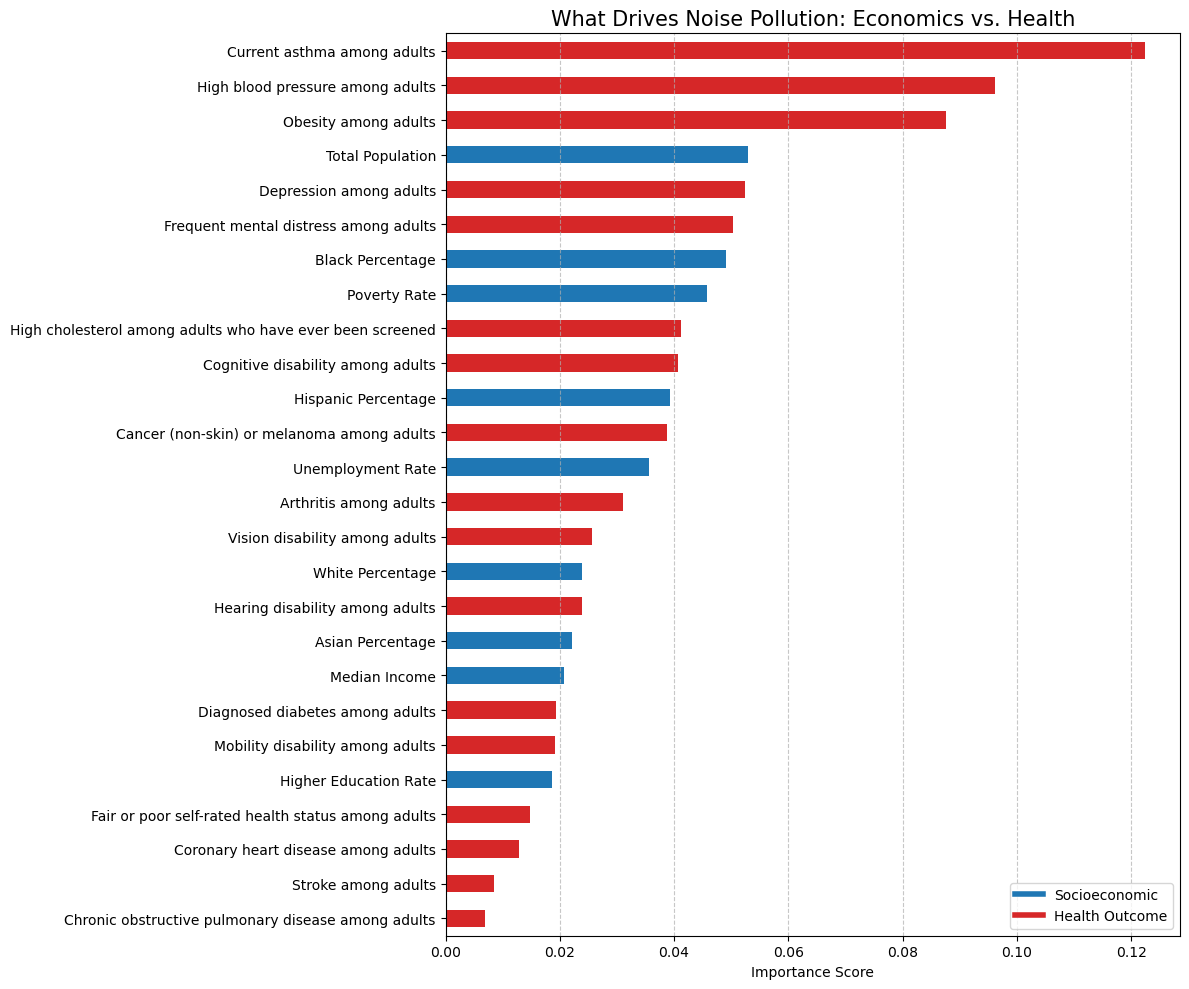

Model R² Score: 0.3760


In [77]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
bar_colors = ['#1f77b4' if x in socio_vars else '#d62728' for x in importances.index]
plt.figure(figsize=(12, 10))
importances.plot(kind='barh', color=bar_colors)
# Create a custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#1f77b4', lw=4, label='Socioeconomic'),
    Line2D([0], [0], color='#d62728', lw=4, label='Health Outcome')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.title('What Drives Noise Pollution: Economics vs. Health', fontsize=15)
plt.xlabel('Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Model R² Score: {rf.score(X, y):.4f}")

testing other regression models

In [73]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

Ridge regression

In [85]:
train_set, test_set = train_test_split(model_data, test_size=0.3, random_state=42)
X_train = train_set[all_features].values
X_train = X_train[:, np.newaxis]
X_test = test_set[all_features].values
X_test = X_test[:, np.newaxis]

y_train = train_set[target].values
y_test = test_set[target].values

In [ ]:
train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)
linear = LinearRegression()
scaler = StandardScaler()
linear.fit(scaler.fit_transform(X_train), y_train)

Regenerating clean 2D training data...
Data successfully split. X_train shape: (60, 34) (Should be 2D)

--- Polynomial Ridge Regression Results ---
Alpha      Train R²   Test R²   
0          1.0000     -7.0960   
10         0.9987     -6.8714   
100        0.9721     -5.7027   
1000       0.8437     -3.9139   
10000      0.5554     -1.7484   

--- Random Forest Tuning Results ---
Max Depth  Train R²   Test R²   
2          0.4575     -1.0157   
5          0.4587     -1.0188   
10         0.4587     -1.0188   
15         0.4587     -1.0188   
None       0.4587     -1.0188   


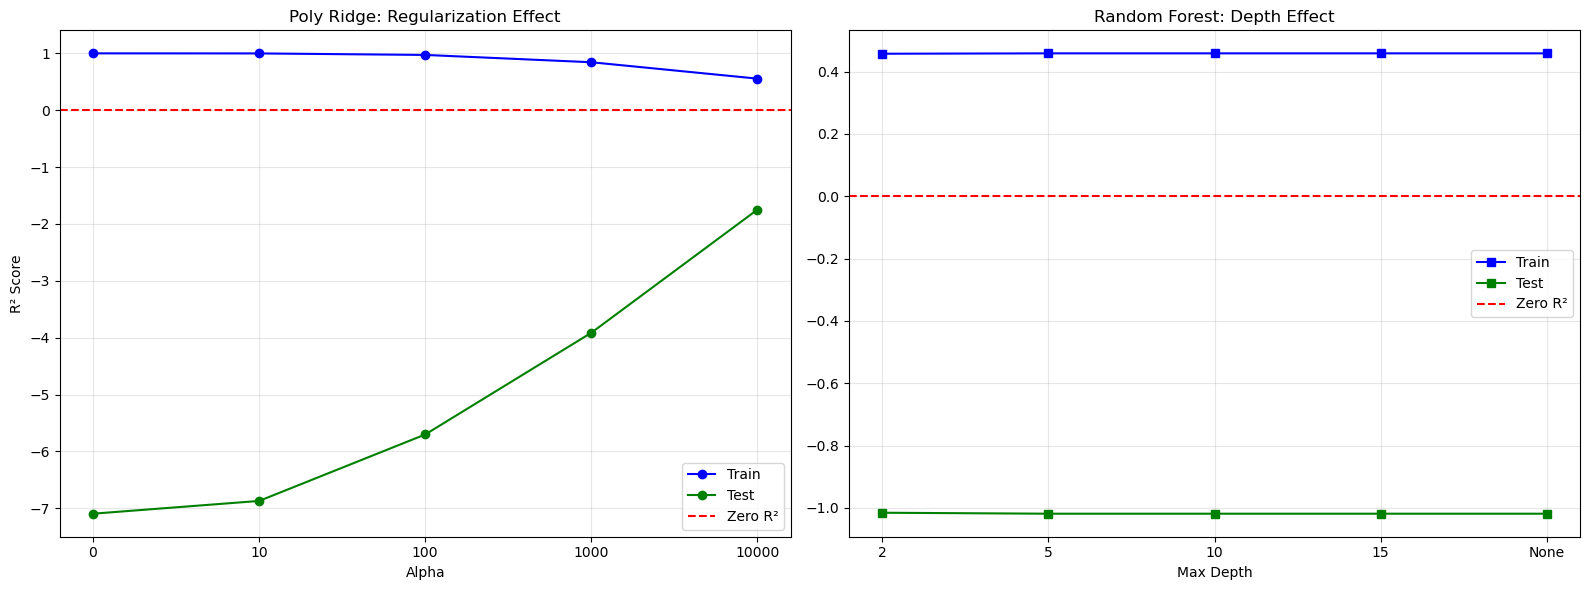

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==========================================
# 1. RE-GENERATE DATA (Crucial Step)
# ==========================================
print("Regenerating clean 2D training data...")

# Ensure inputs are 2D DataFrames
X_fresh = clean_data[features_to_use].dropna()
# Align y and weights to the exact same index as X_fresh
y_fresh = clean_data.loc[X_fresh.index, 'avg_noise_db_county']
w_fresh = clean_data.loc[X_fresh.index, 'percent_covered']

# Perform a fresh split
X_tr, X_te, y_tr, y_te, w_tr, w_te = train_test_split(
    X_fresh, y_fresh, w_fresh, test_size=0.3, random_state=42
)

print(f"Data successfully split. X_train shape: {X_tr.shape} (Should be 2D)")

# ==========================================
# 2. POLYNOMIAL RIDGE REGRESSION TUNING
# ==========================================
alphas = [0, 10, 100, 1000, 10000]
ridge_train_scores = []
ridge_test_scores = []

print("\n--- Polynomial Ridge Regression Results ---")
print(f"{'Alpha':<10} {'Train R²':<10} {'Test R²':<10}")

for alpha in alphas:
    if alpha == 0:
        model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), LinearRegression())
        step_name = 'linearregression'
    else:
        model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), Ridge(alpha=alpha))
        step_name = 'ridge'
    
    # Pass sample weights to the regressor step
    fit_params = {f'{step_name}__sample_weight': w_tr}
    
    try:
        model.fit(X_tr, y_tr, **fit_params)
        
        y_tr_pred = model.predict(X_tr)
        y_te_pred = model.predict(X_te)
        
        tr = r2_score(y_tr, y_tr_pred, sample_weight=w_tr)
        te = r2_score(y_te, y_te_pred, sample_weight=w_te)
    except Exception as e:
        print(f"Error: {e}")
        tr, te = -999, -999
        
    ridge_train_scores.append(tr)
    ridge_test_scores.append(te)
    print(f"{alpha:<10} {tr:<10.4f} {te:<10.4f}")

# ==========================================
# 3. RANDOM FOREST TUNING
# ==========================================
depths = [2, 5, 10, 15, None]
rf_train_scores = []
rf_test_scores = []

print("\n--- Random Forest Tuning Results ---")
print(f"{'Max Depth':<10} {'Train R²':<10} {'Test R²':<10}")

for d in depths:
    rf = RandomForestRegressor(
        n_estimators=100, 
        max_depth=d, 
        min_samples_leaf=10, 
        random_state=42
    )
    
    rf.fit(X_tr, y_tr, sample_weight=w_tr)
    
    tr = rf.score(X_tr, y_tr, sample_weight=w_tr)
    te = rf.score(X_te, y_te, sample_weight=w_te)
    
    rf_train_scores.append(tr)
    rf_test_scores.append(te)
    
    d_str = str(d) if d else "None"
    print(f"{d_str:<10} {tr:<10.4f} {te:<10.4f}")

# ==========================================
# 4. VISUALIZATION
# ==========================================
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Ridge Regression
ax[0].plot([str(a) for a in alphas], ridge_train_scores, marker='o', label='Train', color='blue')
ax[0].plot([str(a) for a in alphas], ridge_test_scores, marker='o', label='Test', color='green')
ax[0].axhline(0, color='red', linestyle='--', label='Zero R²')
ax[0].set_title('Poly Ridge: Regularization Effect')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('R² Score')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Plot 2: Random Forest
ax[1].plot([str(d) if d else "None" for d in depths], rf_train_scores, marker='s', label='Train', color='blue')
ax[1].plot([str(d) if d else "None" for d in depths], rf_test_scores, marker='s', label='Test', color='green')
ax[1].axhline(0, color='red', linestyle='--', label='Zero R²')
ax[1].set_title('Random Forest: Depth Effect')
ax[1].set_xlabel('Max Depth')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Code: Classification of High vs. Low Noise Counties

Noise Threshold: 53.17 dB
Class Balance (0=Low, 1=High): {0: 44, 1: 43}

Model Accuracy: 51.85%
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.57      0.55        14
           1       0.50      0.46      0.48        13

    accuracy                           0.52        27
   macro avg       0.52      0.52      0.52        27
weighted avg       0.52      0.52      0.52        27



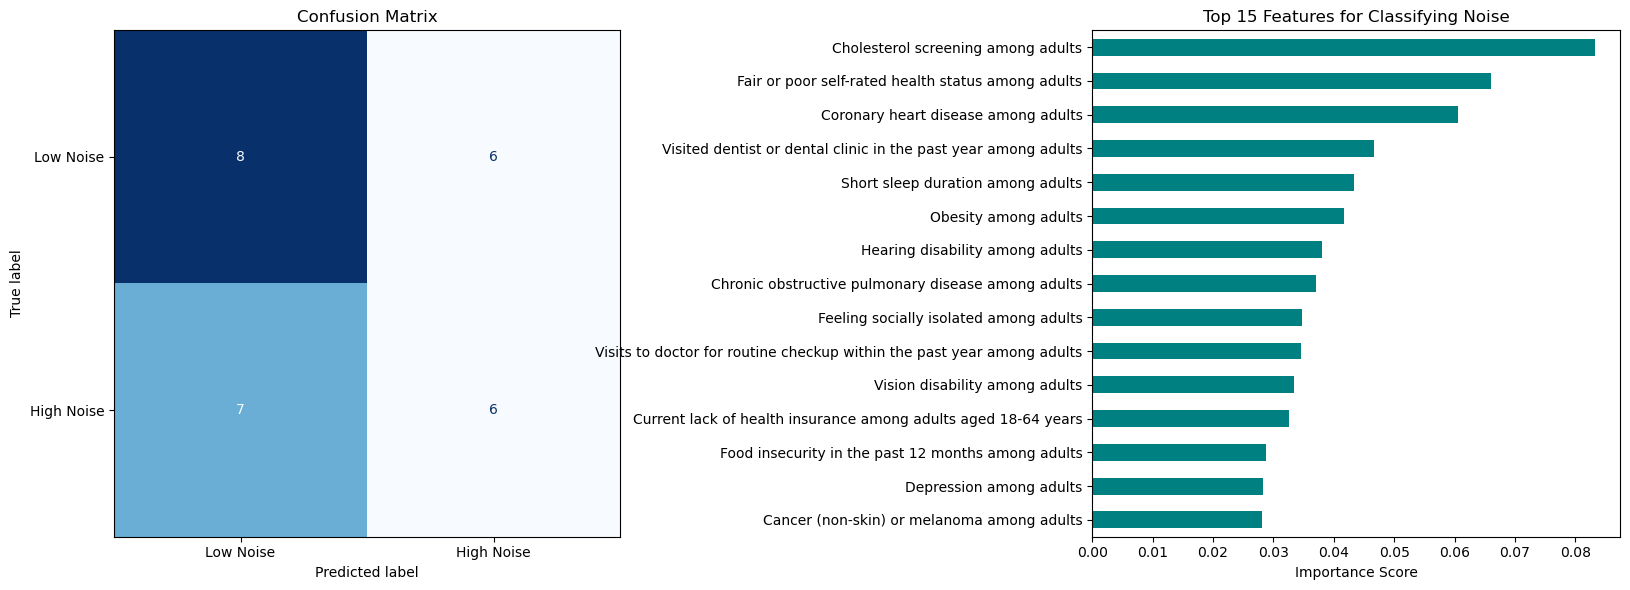

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. DATA PREPARATION
# -------------------
# Re-gather clean data to ensure we avoid previous dimension errors
# We use the same features list you defined earlier
data_class = clean_data[features_to_use + ['avg_noise_db_county', 'percent_covered']].dropna()

X = data_class[features_to_use]
y_continuous = data_class['avg_noise_db_county']
weights = data_class['percent_covered']

# Create Binary Target: 1 if above median (High Noise), 0 if below (Low Noise)
threshold = y_continuous.median()
y_class = (y_continuous > threshold).astype(int)

print(f"Noise Threshold: {threshold:.2f} dB")
print(f"Class Balance (0=Low, 1=High): {y_class.value_counts().to_dict()}")

# Split Data (Stratify ensures we have equal High/Low samples in train & test)
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y_class, weights, test_size=0.3, random_state=42, stratify=y_class
)

# 2. MODEL TRAINING
# -----------------
# Using a Classifier instead of Regressor
clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5,       # Constrain depth to prevent memorization
    min_samples_leaf=5,# Require more samples per leaf
    random_state=42
)

clf.fit(X_train, y_train, sample_weight=w_train)

# 3. EVALUATION
# -------------
y_pred = clf.predict(X_test)

# Calculate Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {acc:.2%}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 4. VISUALIZATION
# ----------------
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Noise', 'High Noise'])
disp.plot(cmap='Blues', ax=ax[0], colorbar=False)
ax[0].set_title("Confusion Matrix")

# Feature Importance Plot
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=True)
# Plot only top 15 for readability
importances.tail(15).plot(kind='barh', color='teal', ax=ax[1])
ax[1].set_title("Top 15 Features for Classifying Noise")
ax[1].set_xlabel("Importance Score")

plt.tight_layout()
plt.show()

Population Weighted

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from rasterstats import zonal_stats
import pygris
import requests
import rasterio
from tqdm import tqdm
import time

# ---------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------
noise_path = "data/CONUS_rail_road_and_aviation_noise_2020/State_rasters/CONUS_merged_noise_map_2020.vrt"

# States: PA, NJ, NY, CT, RI, MA, ME, VT, NH
state_fips = ["42", "34", "36", "09", "44", "25", "23", "50", "33"]

# Optional: Add your Census API key here if you have one to avoid throttling
# Get one here: https://api.census.gov/data/key_signup.html
CENSUS_API_KEY = None 

# ---------------------------------------------------------
# 1. FETCH CENSUS TRACT GEOMETRY (pygris)
# ---------------------------------------------------------
print("1. Fetching Census Tract geometries...")
tracts_list = []
for fips in tqdm(state_fips, desc="Downloading Shapes"):
    try:
        # cb=True gets lighter 'cartographic boundary' files
        t = pygris.tracts(state=fips, year=2020, cb=True, cache=True)
        tracts_list.append(t)
    except Exception as e:
        print(f"   Error geometry for {fips}: {e}")

if not tracts_list:
    raise ValueError("Failed to download any tract geometries.")

all_tracts_gdf = pd.concat(tracts_list, ignore_index=True)
print(f"   Total Tracts found: {len(all_tracts_gdf)}")

# ---------------------------------------------------------
# 2. FETCH POPULATION DATA (Direct API Request)
# ---------------------------------------------------------
print("2. Fetching Population Data (Direct API)...")

def get_census_population(state_fips, api_key=None):
    # ACS 5-Year 2020 Data. Variable B01003_001E is Total Population
    url = "https://api.census.gov/data/2020/acs/acs5"
    params = {
        "get": "NAME,B01003_001E",
        "for": "tract:*",
        "in": f"state:{state_fips}"
    }
    if api_key:
        params['key'] = api_key
        
    r = requests.get(url, params=params)
    if r.status_code != 200:
        raise Exception(f"API Error {r.status_code}: {r.text}")
    
    # Parse JSON response
    data = r.json()
    headers = data[0]
    rows = data[1:]
    return pd.DataFrame(rows, columns=headers)

pop_list = []
for fips in tqdm(state_fips, desc="Querying Census"):
    try:
        df = get_census_population(fips, CENSUS_API_KEY)
        pop_list.append(df)
        time.sleep(0.5) # Be nice to the API
    except Exception as e:
        print(f"   Failed to get pop for {fips}: {e}")

if not pop_list:
    raise ValueError("Failed to download any population data. Check internet connection or API limits.")

all_pop_df = pd.concat(pop_list, ignore_index=True)

# Create GEOID for joining: State + County + Tract
all_pop_df["GEOID"] = all_pop_df["state"] + all_pop_df["county"] + all_pop_df["tract"]
all_pop_df["Population"] = pd.to_numeric(all_pop_df["B01003_001E"], errors='coerce').fillna(0)

print("3. Merging Geometry and Population...")
# Join on GEOID
tracts_gdf = all_tracts_gdf.merge(all_pop_df[['GEOID', 'Population']], on='GEOID', how='inner')

# ---------------------------------------------------------
# 3. REPROJECT AND CALCULATE NOISE
# ---------------------------------------------------------
print("4. Aligning projections...")
# CRITICAL STEP: Tracts must be in same CRS as Raster for zonal_stats to work
with rasterio.open(noise_path) as src:
    noise_crs = src.crs
    print(f"   Raster CRS: {noise_crs}")
    
    # Reproject tracts to match raster
    if tracts_gdf.crs != noise_crs:
        tracts_gdf = tracts_gdf.to_crs(noise_crs)
        print("   Tracts reprojected successfully.")

print("5. Calculating Noise per Tract (Zonal Stats)...")
stats = zonal_stats(
    tracts_gdf,
    noise_path,
    stats=['mean'],
    nodata=0
)

tracts_gdf['tract_avg_noise'] = [s['mean'] for s in stats]
tracts_clean = tracts_gdf.dropna(subset=['tract_avg_noise'])

# ---------------------------------------------------------
# 4. AGGREGATE TO COUNTY (WEIGHTED AVERAGE)
# ---------------------------------------------------------
print("6. Calculating Weighted Averages...")

# Create County FIPS for grouping
tracts_clean['COUNTY_FIPS'] = tracts_clean['STATEFP'] + tracts_clean['COUNTYFP']

def weighted_average(group):
    # Formula: Sum(Noise * Pop) / Sum(Pop)
    d = group['tract_avg_noise']
    w = group['Population']
    
    # Handle counties with 0 population (avoid div by zero)
    if w.sum() == 0:
        return np.nan
        
    return np.average(d, weights=w)

county_noise = tracts_clean.groupby('COUNTY_FIPS').apply(weighted_average).reset_index()
county_noise.columns = ['FIPS', 'pop_weighted_noise']

# ---------------------------------------------------------
# 5. OUTPUT
# ---------------------------------------------------------
print("\n--- DONE ---")
print(county_noise.head())

# You can now merge this back to your main dataset:


1. Fetching Census Tract geometries...


2. Fetching Population Data (Direct API)...


Querying Census:  11%|█         | 1/9 [00:00<00:01,  5.78it/s]

   Failed to get pop for 42: API Error 400: error: unknown variable 'state'


Querying Census:  22%|██▏       | 2/9 [00:00<00:00,  7.18it/s]

   Failed to get pop for 34: API Error 400: error: unknown variable 'state'


Querying Census:  33%|███▎      | 3/9 [00:00<00:00,  7.69it/s]

   Failed to get pop for 36: API Error 400: error: unknown variable 'state'


Querying Census:  44%|████▍     | 4/9 [00:00<00:00,  7.36it/s]

   Failed to get pop for 09: API Error 400: error: unknown variable 'state'


Querying Census:  67%|██████▋   | 6/9 [00:00<00:00,  5.92it/s]

   Failed to get pop for 44: API Error 400: error: unknown variable 'state'
   Failed to get pop for 25: API Error 400: error: unknown variable 'state'
   Failed to get pop for 23: API Error 400: error: unknown variable 'state'


Querying Census: 100%|██████████| 9/9 [00:01<00:00,  6.90it/s]

   Failed to get pop for 50: API Error 400: error: unknown variable 'state'
   Failed to get pop for 33: API Error 400: error: unknown variable 'state'


ValueError: Failed to download any population data. Check internet connection or API limits.

Others

In [74]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    "SVR": SVR(kernel='rbf')
}

In [75]:
results = []
fitted_models = {}

for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train, sample_weight=w_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Calculate Metrics
    r2 = r2_score(y_test, y_pred, sample_weight=w_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append({"Model": name, "R2": r2, "RMSE": rmse})
    fitted_models[name] = model

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print(results_df)

               Model        R2      RMSE
5      Random Forest -0.366826  0.825462
7                SVR -0.372193  0.940403
2              Lasso -0.503176  0.889164
6  Gradient Boosting -0.653549  0.924298
3         ElasticNet -0.672350  0.902853
1              Ridge -2.204097  1.078869
4      Decision Tree -2.257065  1.142701
0  Linear Regression -2.522797  1.101907


### Conclusions from RF significance plot
Dominant driver is population density, which shows that noise is a proxy for urbanization. This makes me wonder if I can account for poopulation density in the model to see if noise pollution still has an effect on health outcomes after controlling for population density.

High blood pressure being the secodn strongest driver and depression being the fifth strongest aligns with medical literature on noise. With Chronic exposure to noise pollution, the body's stress response is activated, leading to increased production of stress hormones like cortisol and adrenaline. Over time, this chronic stress can contribute to the development of hypertension (high blood pressure) as the cardiovascular system is consistently under strain. While this model can't prove causality, it is undeniably a strong link. 

Another finding is that transportation noise is disproportionaley concentrated in communities of color and low income communities. This aligns with environmental justice literature on noise pollution.